In [28]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from diffusers import AutoPipelineForText2Image
from train_video import RateDistortionLoss
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np

In [2]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [3]:
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [4]:
caption = predict_step(['Jockey/img00001.png']) #['a man riding a horse on top of a track']

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [5]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

Loading pipeline components...: 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00,  8.88it/s]


['a man riding a horse on top of a track']


100%|█████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.29it/s]


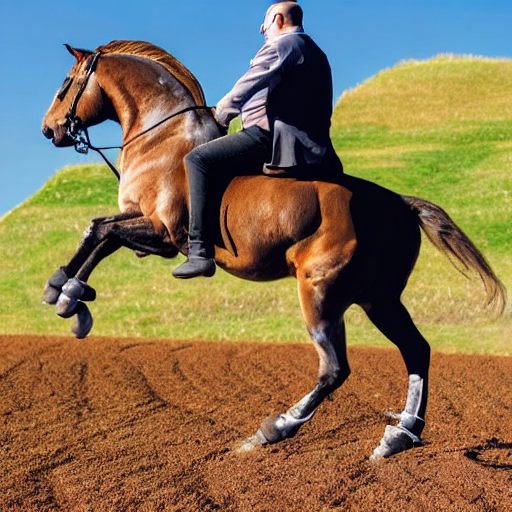

In [6]:
print(caption)
image = pipeline(
	caption
).images[0]
image

In [27]:
image.save('vit_gpt2_img.png')

In [7]:
criterion = RateDistortionLoss(lmbda=1e-2, return_details=True)

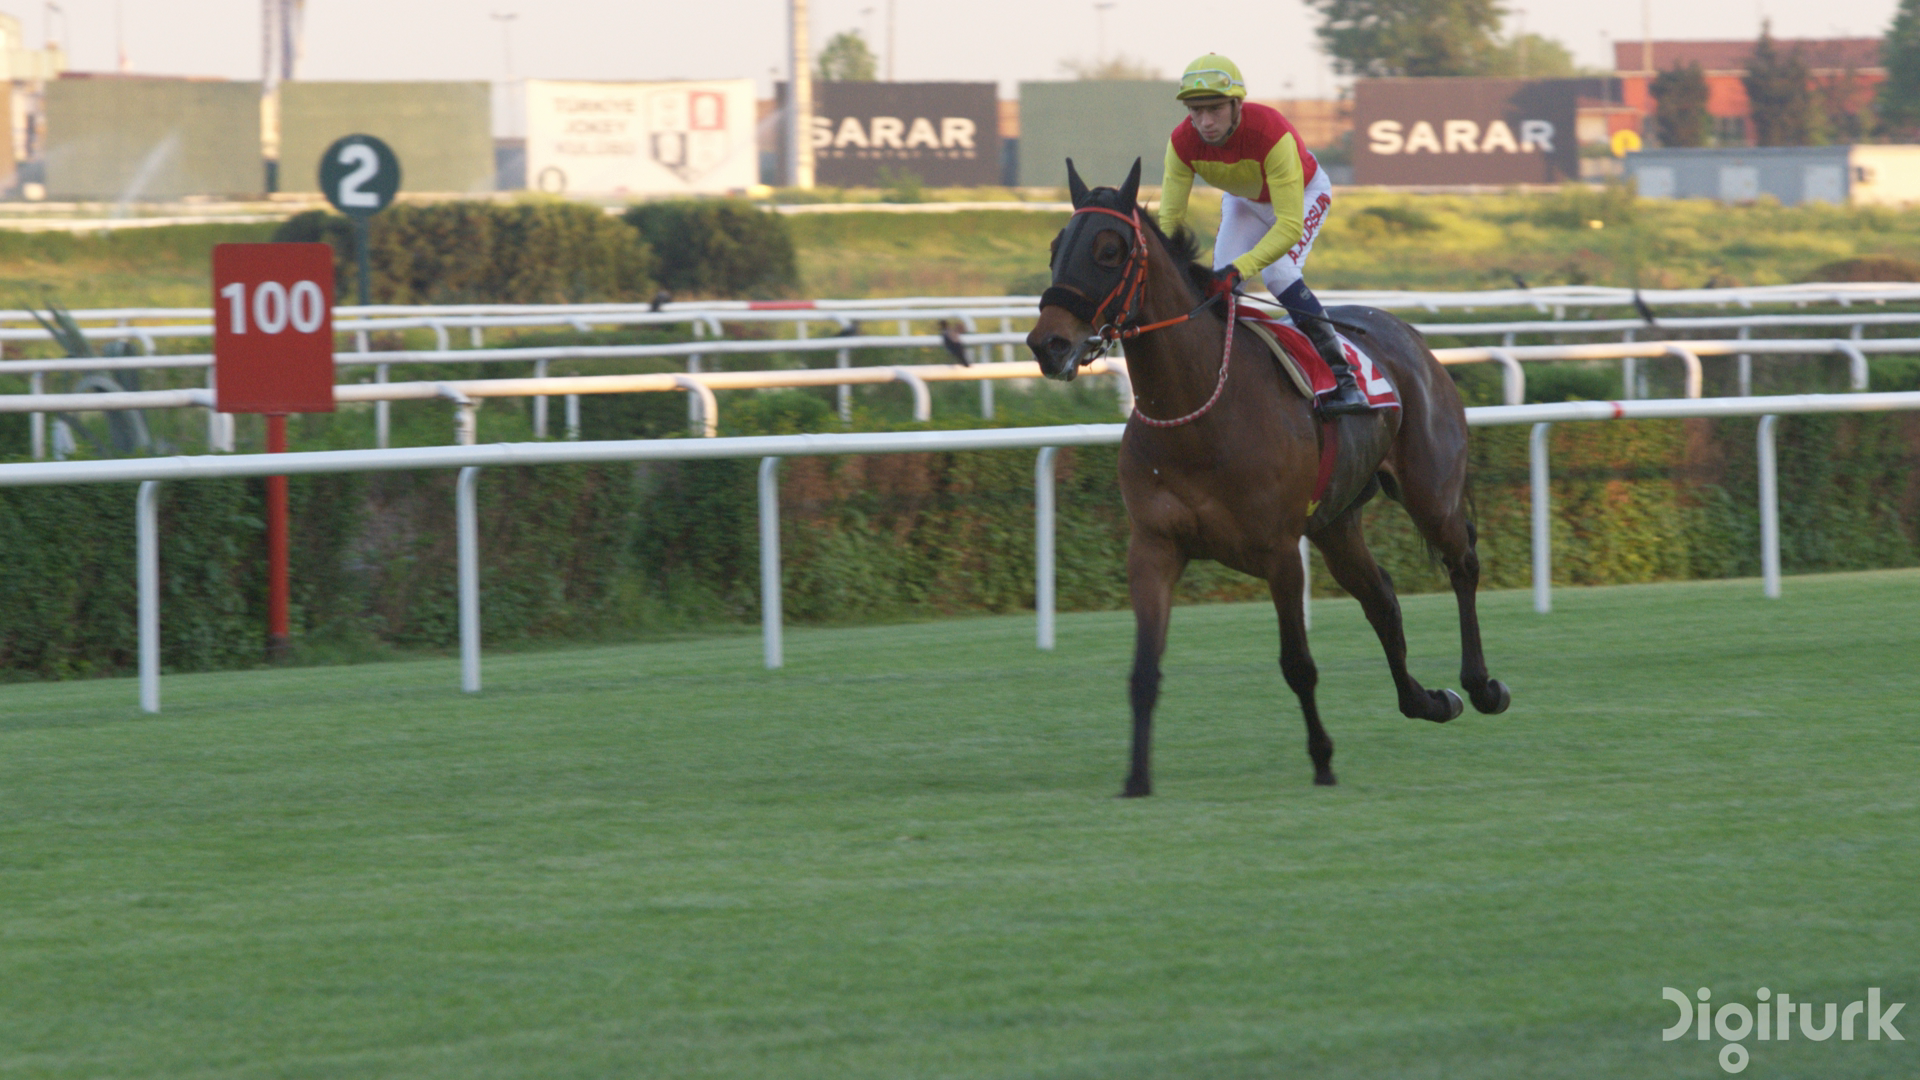

In [8]:
image_orig = Image.open('Jockey/img00001.png')
image_orig

In [9]:
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/transformers/models/llava/configuration_llava.py:104: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
prompt = "<image>\nUSER:Give a detailed visual description of this image ?\nASSISTANT:"
inputs = processor(text=prompt, images=image_orig, return_tensors="pt")

# Generate
generate_ids = model.generate(**inputs, max_length=200)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

'\nUSER:Give a detailed visual description of this image ?\nASSISTANT: The image features a man riding a brown horse on a grassy field. The man is wearing a yellow shirt and a red and white hat, which adds a pop of color to the scene. The horse is galloping, and the man appears to be enjoying the ride.\n\nIn the background, there are several birds scattered around the field, adding to the natural atmosphere of the scene. The overall setting is a lively and engaging outdoor environment.'

100%|█████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.89it/s]


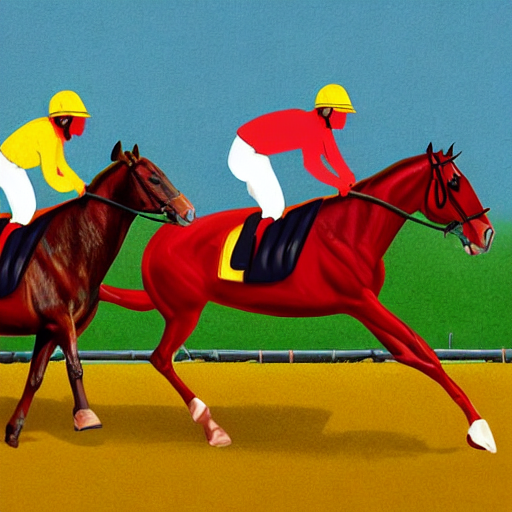

In [36]:
image2 = pipeline(
	'The image features a jockey riding a brown horse on a grassy track. The jockey is wearing a yellow and red outfit, and the horse is wearing a red bridle. The natural scene captures the excitement and energy of a horse race, with the jockey skillfully guiding the horse around the track. The horse and jockey are the main focus of the image.'
).images[0]
image2

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. the overall setting is a lively and engaging outdoor environment.']
100%|█████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.14it/s]


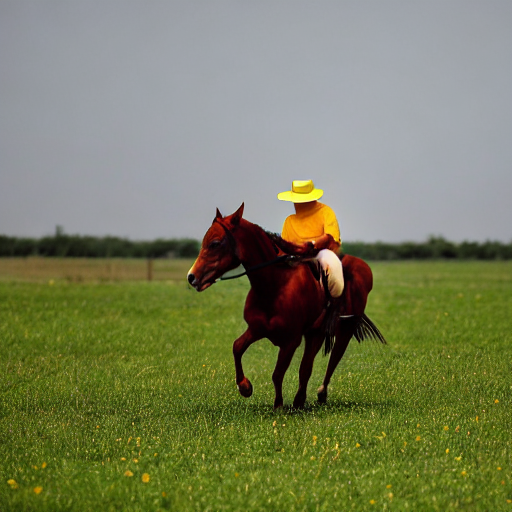

In [32]:
image3 = pipeline(
	'The image features a man riding a brown horse on a grassy field. The man is wearing a yellow shirt and a red and white hat, which adds a pop of color to the scene. The horse is galloping, and the man appears to be enjoying the ride.\n\nIn the background, there are several birds scattered around the field, adding to the natural atmosphere of the scene. The overall setting is a lively and engaging outdoor environment.'
).images[0]
image3

In [37]:
image2.save('llava_img3.png')

In [29]:
def calculate_psnr(original_image, reconstructed_image):
    # Convert images to numpy arrays
    original_array = np.array(original_image)
    reconstructed_array = np.array(reconstructed_image)

    # Calculate mean squared error
    mse = np.mean((original_array - reconstructed_array) ** 2)

    # Maximum possible pixel value
    max_pixel_value = 255  # Assuming 8-bit images

    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr

In [ ]:
# Load original and reconstructed images
original_image = Image.open('original_image.png')
reconstructed_image = Image.open('reconstructed_image.png')

# Calculate PSNR
psnr = calculate_psnr(original_image, reconstructed_image)

# Print PSNR
print('PSNR:', psnr)